In [10]:
# 1. Імпорт бібліотек
from google.colab import files
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

sns.set(style="whitegrid")

In [ ]:
# # 2. Шляхи
# BASE_DIR = Path("..")
# DATA_PATH = BASE_DIR / "data" / "df1_mean.csv"
# MODELS_DIR = BASE_DIR / "models"
# MODEL_PATH = MODELS_DIR / "best_model_lgb.pkl"
# SCALER_PATH = MODELS_DIR / "scaler.pkl"

# print("DATA_PATH ->", DATA_PATH)
# print("MODEL_PATH ->", MODEL_PATH)


DATA_PATH -> ..\data\df1_mean.csv
MODEL_PATH -> ..\models\best_model_lgb.pkl


In [2]:
uploaded = files.upload()

Saving df1_mean.csv to df1_mean.csv


In [11]:
# 3. Завантаження даних
from google.colab import files

df = pd.read_csv('df1_mean.csv')
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
if 'Churn' in df.columns and 'churn' not in df.columns:
    df.rename(columns={'Churn': 'churn'}, inplace=True)

X = df.drop(columns=['churn'])
y = df['churn']

# Розділення даних (нове, контрольне)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (57514, 10) Test shape: (14379, 10)


In [12]:
binary_cols = [c for c in X.columns if X[c].nunique() <= 2]
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [c for c in num_cols if c not in binary_cols]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


In [13]:
# 5. Навчання фінальної моделі LightGBM
best_params = {
    "learning_rate": 0.05,
    "max_depth": -1,
    "n_estimators": 300,
    "num_leaves": 63,
    "subsample": 0.8,
    "random_state": 42,
    "force_row_wise": True,
    "verbose": -1
}

model = LGBMClassifier(**best_params)
model.fit(X_train_scaled, y_train)


LGBMClassifier(force_row_wise=True, learning_rate=0.05, n_estimators=300,
               num_leaves=63, random_state=42, subsample=0.8, verbose=-1)

In [6]:
# 4. Завантаження scaler та моделі
# scaler = joblib.load('scaler.pkl')
# model = joblib.load("best_model_lgb.pkl")
# print("✅ Модель та scaler завантажено успішно.")

# # Масштабування тестових даних
# binary_cols = [c for c in X.columns if X[c].nunique() <= 2]
# num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# cols_to_scale = [c for c in num_cols if c not in binary_cols]

# X_test_scaled = X_test.copy()
# X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Модель та scaler завантажено успішно.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
# 5. Прогноз та метрики
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print(f"\n📊 Результати на відкладеному тесті:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")


📊 Результати на відкладеному тесті:
Accuracy: 0.9467
Precision: 0.9605
Recall: 0.9432
F1-score: 0.9518
ROC-AUC: 0.9836


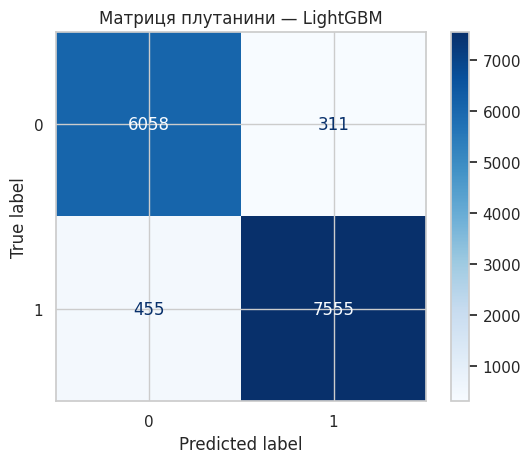

In [15]:
# 6. Матриця плутанини (Confusion Matrix)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Матриця плутанини — LightGBM")
plt.show()

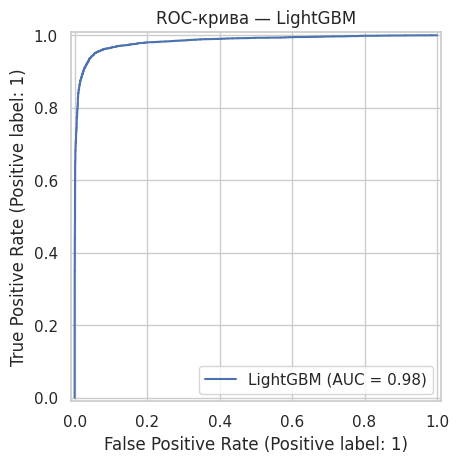

In [16]:
# 7. ROC-крива
RocCurveDisplay.from_predictions(y_test, y_proba, name="LightGBM")
plt.title("ROC-крива — LightGBM")
plt.show()

In [ ]:
# # 8. Збереження результатів у CSV
# results = pd.DataFrame([{
#     "model": "LightGBM_final",
#     "accuracy": acc,
#     "precision": prec,
#     "recall": rec,
#     "f1": f1,
#     "roc_auc": roc
# }])

# results_path = MODELS_DIR / "final_evaluation_results.csv"
# results.to_csv(results_path, index=False)
# print(f"\n✅ Результати тестування збережено у: {results_path}")


✅ Результати тестування збережено у: ..\models\final_evaluation_results.csv
